# Analisi multiprocessing

Di seguito alcune considerazioni sull'utilizzo
del multiprocessing per la parallelizzazione di
un algoritmo genetico.


## Motivazioni

L'utilizzo del modulo `multiprocessing` è ciò che
viene considerato lo standard per il calcolo
parallelo in Python, soprattutto se si parla di
task CPU bound.

Permette di aggirare il problema introdotto dal
GIL, il quale non permette il classico paradigma
multithread, possibile in altri linguaggi come C o
C++.

Tramite multiprocessing è dunque possibile non
scendere a compromessi in quanto ad espressività
del codice. Il programmatore è libero di scrivere
il suo algoritmo genetico utilizzato tipi e
strutture dati native di Python e, se necessario
può ricorrere a librerie di terze parti senza
problemi.


### Problematiche

Il multiprocessing di contro non è la cosa più
leggera che ci sia. Di certo non è possibile
pensare ad un approccio in cui i processi vengono
creati e distrutti ad ogni iterazione, in quanto
si genererebbe del dell'overhead sicuramente non
trascurabile.

La scelta di creare un pool di processi worker che
rimane in vita dall'inizio alla fine
dell'esecuzione è dunque una scelta quasi obbligata
e che introduce la necessità di un qualche
meccanismo di sincronizzazione per avviare e
mettere in attesa i processi.

L'altro potenziale limite è l'assenza di memoria
condivisa. Non è dunque possibile avere strutture
dati condivise tramite puntatori o definite
globalmente a cui ogni processi può accedere. Anche
qui la scelta di condividere parti della struttura
dati tramite qualche meccanismo di streaming dati
è praticamente obbligata.


#### Memoria condivisa

Esiste la possibilità di creare un blocco di
memoria condivisa che risiede al di fuori di ogni
worker e al quale è possibile accedere in modo
diretto come si farebbe tramite multithreading.

Ho trovato tuttavia questo meccanismo molto
limitante per l'espressività che vorrebbe in
qualche modo garantire la libreria. Il motivo è
che per riuscire a accedere direttamente al blocco
di memoria lo si deve fare tramite oggetti che
supportano il **Buffer Protocol** di Python, come
ad esempio _numpy array_ o _bytearray_.

Questo limita molto i tipi e le strutture dati
che si vogliono impiegare e ci spinge ad un
approccio più classico in cui possiamo manipolare
solo array numerici o simili.

Non sarebbe quindi possibile avere cromosomi
dalla struttura complessa ma soprattutto
personalizzata.


## Modello di calcolo parallelo

Il modello di calcolo proposto si offre di operare
in parallelo nelle fasi di crossover, mutazione e
valutazione.

Una volta selezionati gli individui per la
riproduzione, si suddivide la lista che li contiene
in $W$ chunk uguali, dove $W$ è il numero di
processi worker. Ciascun chunk viene poi inviato
ai worker.

Per la condivisione ho optato per un meccanismo
basato su code (`multiprocessing.Queue`) di
comunicazione. Ogni processo possiede due code, una
per la ricezione dati, l'altra per l'invio.

![queue](images/queue.svg)

Le code permettono di implementare in modo molto
semplice il paradigma _produttore-consumatore_,
fornendo due metodi principali (`put` e `get`)
che permettono rispettivamente di

- Inserire un elemento nella coda. Se questa è
  piena il processo si blocca finché non vi è
  uno slot libero.
- Estrarre un elemento dalla coda. Nel caso in cui
  questa sia vuota ci si blocca in attesa che un
  elemento venga inserito.

Per velocizzare ulteriormente l'invio e la
ricezione dati ho fatto uso della libreria
`asyncio`, la quale, tramite la sintassi
`async`/`await` permette di effettuare operazioni
I/O bound in modo asincrono.


### Prestazioni della coda

Per valutare la bontà del modello ho preso in considerazione il tempo
necessario a

- inserire un singolo individuo in coda.
- effettuare le operazioni di crossover, mutazione e valutazione per un singolo
  individuo.
- effettuare le due operazioni precedenti ma per un gruppo di individui.


In [1]:
import sys

# chromosome length
chromosome = [i for i in range(500)]
print(f"chromosome size: {sys.getsizeof(chromosome) / 1024.0:.2f} KB")

chromosome size: 4.12 KB


Passiamo ora a costruire 3 diverse popolazioni, rispettivamente da $10.000$,
$20.000$ e $50.0000$ individui.


In [2]:
import pandas as pd

population_sizes = [10000, 20000, 50000]
populations = [[chromosome for _ in range(size)] for size in population_sizes]

populations_df = {
    "individuals": [size for size in population_sizes],
    "size (KB)": [sys.getsizeof(pop) / 1024.0 for pop in populations],
}

populations_df = pd.DataFrame(populations_df)
populations_df

,individuals,size (KB)
0,10000,83.179688
1,20000,168.960938
2,50000,433.960938


Per ognuna delle popolazioni andiamo a valutare il tempo medio di inserimento
ed estrazione di un individuo nella coda.


In [3]:
import multiprocessing as mp
import time

import pandas as pd

dfs = []

buffer = mp.Queue()
single_timings = {"size": [], "put time (ms)": [], "get time (ms)": []}
for p, size in zip(populations, population_sizes):
    for _ in range(size):
        start = time.perf_counter()
        buffer.put(chromosome)
        put_end = time.perf_counter()
        buffer.get()
        get_end = time.perf_counter()

        single_timings["size"].append(size)
        single_timings["put time (ms)"].append((put_end - start) * 1000.0)
        single_timings["get time (ms)"].append((get_end - put_end) * 1000.0)

single_timings = pd.DataFrame(single_timings)
single_timings.groupby("size").mean()

,put time (ms),get time (ms)
size,,
10000,0.015178,0.056589
20000,0.018066,0.067917
50000,0.017912,0.076320


Vediamo invece il tempo totale di inserimento ed estrazione di tutti gli
individui uno per uno.


In [4]:
single_timings.groupby("size").sum()

,put time (ms),get time (ms)
size,,
10000,151.780778,565.888723
20000,361.323032,1358.331638
50000,895.592960,3816.014501


Andiamo ora a valutare il tempo necessario ad inserire ed estrarre l'intera
popolazione in un colpo solo.


In [5]:
assert buffer.empty()

whole_pop_timings = {"size": [], "put time (ms)": [], "get time (ms)": []}
for pop, size in zip(populations, population_sizes):
    start = time.perf_counter()
    buffer.put(pop)
    put_end = time.perf_counter()
    buffer.get()
    get_end = time.perf_counter()

    whole_pop_timings["size"].append(size)
    whole_pop_timings["put time (ms)"].append((put_end - start) * 1000.0)
    whole_pop_timings["get time (ms)"].append((get_end - put_end) * 1000.0)

whole_pop_timings = pd.DataFrame(whole_pop_timings)
whole_pop_timings

,size,put time (ms),get time (ms)
0,10000,0.043095,0.550495
1,20000,0.033571,0.774062
2,50000,0.047266,1.459415


Andiamo a comparare i tempi medi di inserimento ed estrazione di un singolo
individuo con i tempi necessari ad inserire ed estrarre l'intera popolazione.


In [6]:
whole_pop_timings.groupby("size").sum() / single_timings.groupby("size").mean()

,put time (ms),get time (ms)
size,,
10000,2.839292,9.727973
20000,1.858226,11.397246
50000,2.638810,19.122241


Prendiamo ad esempio la popolazione da $50.000$ individui, con un peso totale
di circa $433$ KB. Si nota subito che occupa almeno 100 volte la memoria
occupata da un singolo cromosoma. Ad ogni modo, il tempo di estrazione
dell'intera popolazione non è 100 volte superiore ma circa 23 volte superiore.

Compariamo ora il tempo necessario ad inserire ed estrarre l'intera popolazione
un individuo alla volta, con il tempo necessario ad inserirla ed estrarla in un
colpo solo.


In [7]:
single_timings.groupby("size").sum() / whole_pop_timings.groupby("size").sum()

,put time (ms),get time (ms)
size,,
10000,3522.004331,1027.963423
20000,10762.950784,1754.809870
50000,18947.932347,2614.756256


Risulta chiaro il vantaggio che si inserendo più dati alla volta ma meno volte
rispetto ad inserire pochi byte per volta ma molte volte.

Per quanto riguarda invece il singolo inserimento o estrazione dalla coda,
lavorare con meno byte risulta più vantaggioso ma il miglioramento è di gran
lunga più marcato nel caso in cui si lavori con l'intera popolazione in blocco.


#### Suddivisione della popolazione in chunk

Al fine di migliorare il modello che ho implementato, è interessante vedere
la differenza in prestazioni quando si suddivide la popolazione in chunk.

Per ognuna delle popolazioni ho valutato chunk di dimensioni pari alla
popolazione stessa e poi via via più piccoli dividendo per 2.


In [8]:
import math

chunk_df = {"size": [], "chunksize": [], "put time (ms)": [], "get time (ms)": []}

for size, pop in zip(population_sizes, populations):
    chunksize = size
    for _ in range(6):
        for i in range(0, len(pop), chunksize):
            start = time.perf_counter()
            buffer.put(pop[i : i + chunksize])
            put_end = time.perf_counter()
            buffer.get()
            get_end = time.perf_counter()

            chunk_df["size"].append(size)
            chunk_df["chunksize"].append(chunksize)
            chunk_df["put time (ms)"].append((put_end - start) * 1000.0)
            chunk_df["get time (ms)"].append((get_end - put_end) * 1000.0)

        chunksize = math.ceil(chunksize / 2)

chunk_df = pd.DataFrame(chunk_df)
chunk_df

,size,chunksize,put time (ms),get time (ms)
0,10000,10000,0.063350,1.353053
1,10000,5000,0.041483,0.617103
2,10000,5000,0.039917,0.220918
3,10000,2500,0.026442,0.124709
4,10000,2500,0.023326,0.165428
...,...,...,...,...
184,50000,1563,0.018385,0.071181
185,50000,1563,0.015814,0.072592
186,50000,1563,0.015482,0.156522
187,50000,1563,0.015621,0.079789


In [9]:
import matplotlib.pyplot as plt


def plot_chunk(size: int):
    df = chunk_df[chunk_df["size"] == size]
    chunksizes = df["chunksize"].unique()
    mean_put = df.groupby("chunksize").mean()["put time (ms)"]
    mean_get = df.groupby("chunksize").mean()["get time (ms)"]

    tot_put = df.groupby("chunksize").sum()["put time (ms)"]
    tot_get = df.groupby("chunksize").sum()["get time (ms)"]

    fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    axes[0].set_title(f"Population size: {size}")
    axes[0].set_xlabel("Chunksize")
    axes[0].set_ylabel("Operation time")
    axes[0].set_xscale("log")

    axes[0].plot(chunksizes, mean_put, label=f"mean put time", marker="s")
    axes[0].plot(chunksizes, mean_get, label=f"mean get time", marker="s")

    axes[0].legend()
    axes[0].grid()

    axes[1].set_title(f"Population size: {size}")
    axes[1].set_xlabel("Chunksize")
    axes[1].set_ylabel("Operation time")
    axes[1].set_xscale("log")

    axes[0].plot(chunksizes, tot_put, label=f"total put time", marker="s")
    axes[0].plot(chunksizes, tot_get, label=f"total get time", marker="s")

    axes[1].legend()
    axes[1].grid()

/tmp/ipykernel_40340/150220737.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_40340/150220737.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_40340/150220737.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


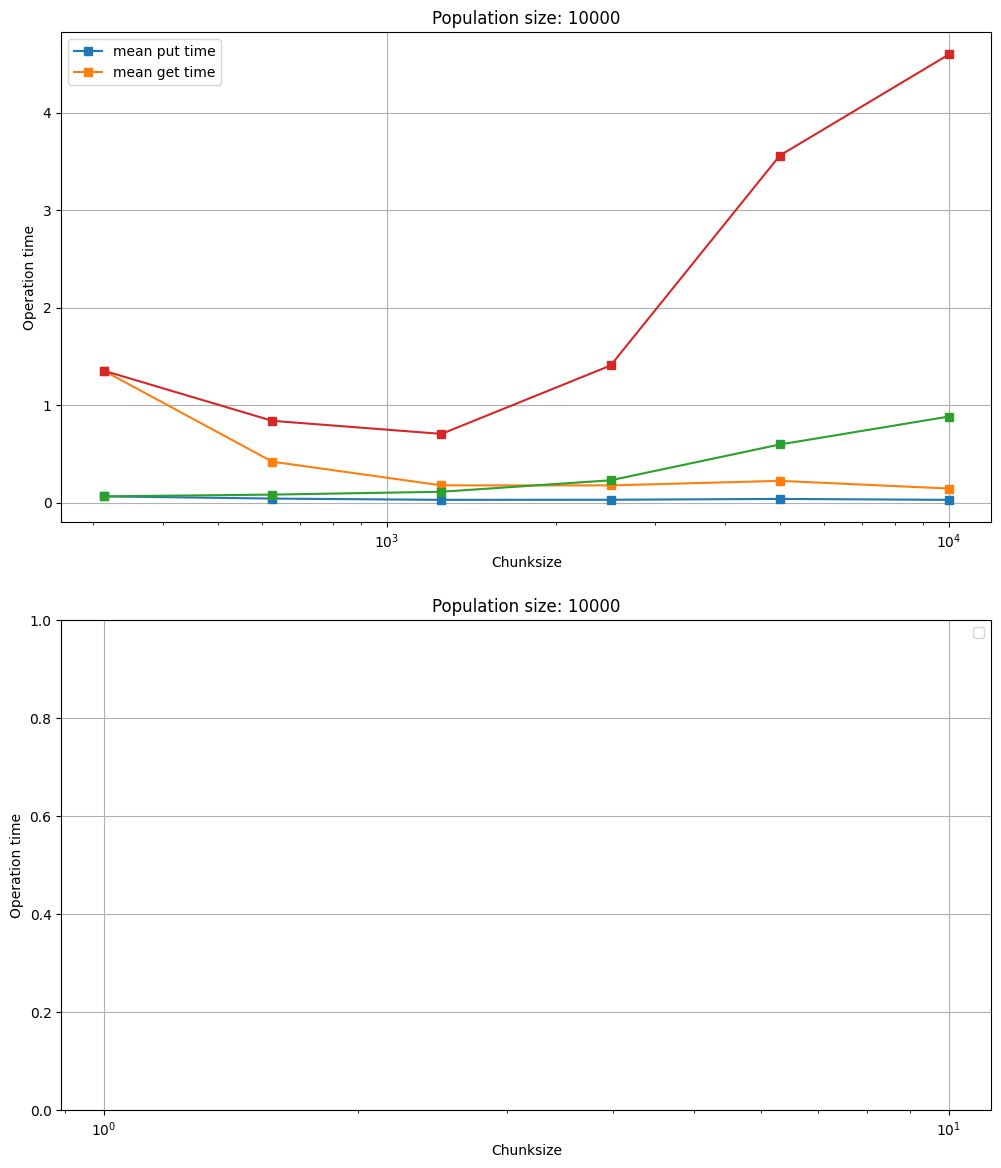

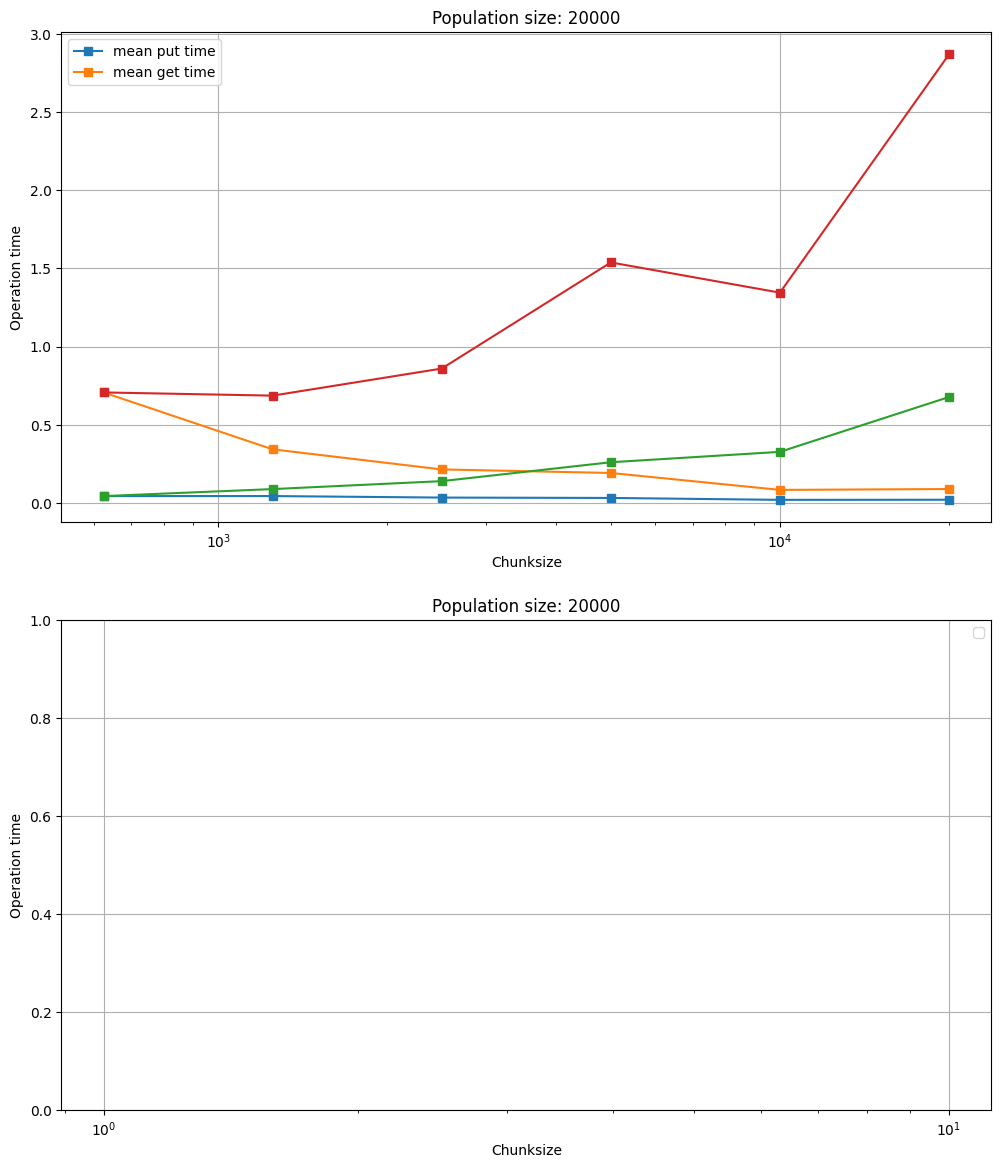

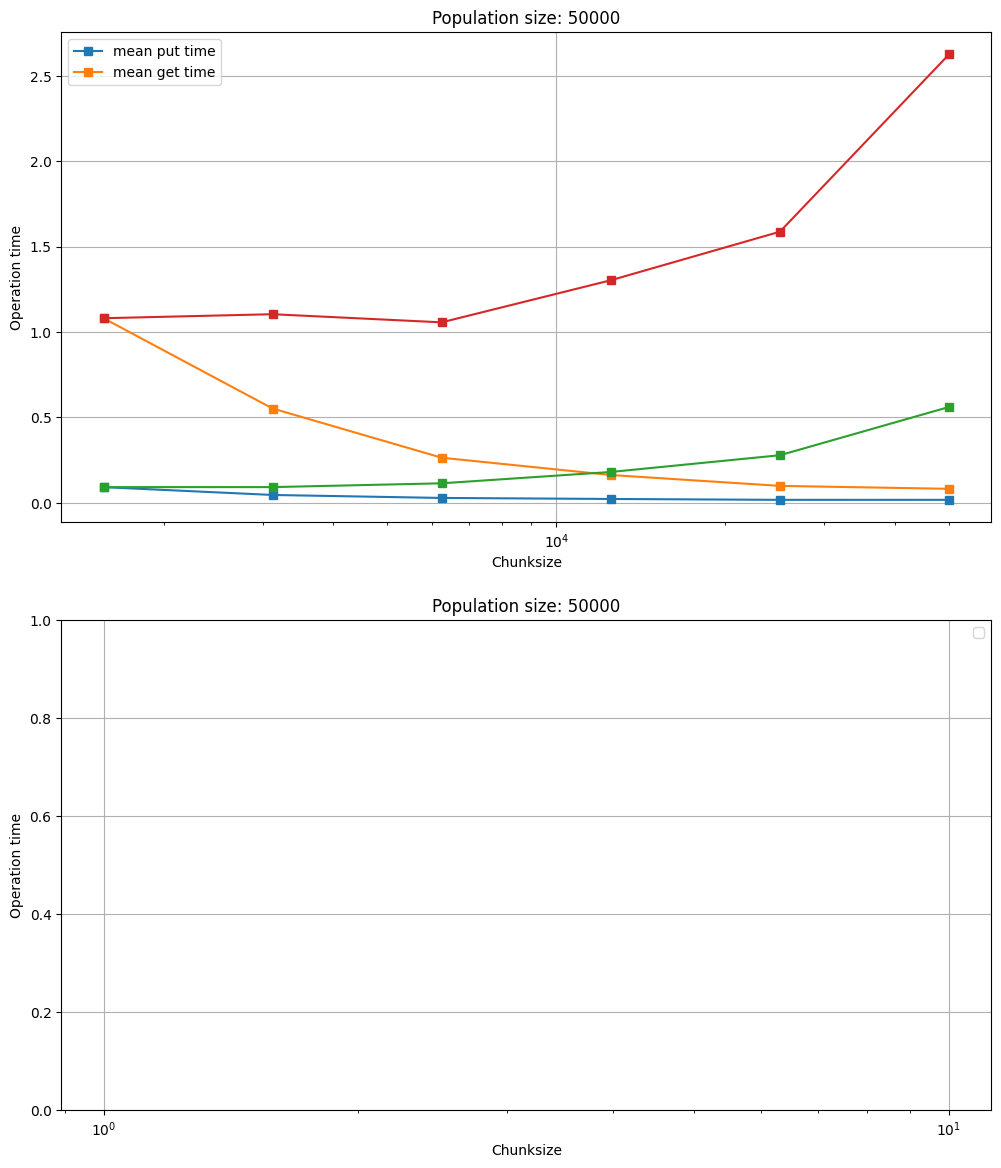

In [10]:
plot_chunk(10000)
plot_chunk(20000)
plot_chunk(50000)